In [1]:
import pandas as pd
import numpy as np
import os
from collections import defaultdict
import json

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Segregates the MAGPIE PIEs into different groups
For the error analysis and to study the idiom principle, the MAGPIE PIEs are grouped into different lists based on their characteristics.

The characteristics are observed in the MAGPIE as well as preprocessed CommonCrawl News corpus.

In [3]:
data_dir = '../data'
magpie_tokens_file = data_dir + '/token_files/option1_idioms.csv'

# Combined magpie datasets
magpie_data_file = '../experiments/exp3A_1/tmp/magpie_full_exp3A_1.csv'

In [4]:
output_file = data_dir + '/PIE_segregation/pie_segregation.csv'

In [5]:
# Load the token mapping
df_token_mapping = pd.read_csv(magpie_tokens_file)
magpie_token_set = set(df_token_mapping['idiom_token'].values)
print(f"Total num of tokens: {len(magpie_token_set)}")

Total num of tokens: 1738


In [6]:
LABEL_IDIOM = 'idiom'
LABEL_LITERAL = 'literal'

In [7]:
df_magpie = pd.read_csv(magpie_data_file)
# Convert the labels from 0 and 1 to idiom and literal, for visualization purpose
df_magpie['label'] = df_magpie['label'].map(lambda l: LABEL_IDIOM if l==0 else LABEL_LITERAL)
df_magpie

,sentence_0,label
0,"For example , with fell running and mountain m...",idiom
1,I 'd keep him well IDintherunningID .,idiom
2,"He IDgivesomeonethecreepsID , so I looked roun...",idiom
3,"‘ He 's IDdosomeoneproudID , as well,’ says Gr...",idiom
4,"People quickly embraced formal democracy , but...",idiom
...,...,...
48390,"IDinanutshellID , I see N C V O as something l...",idiom
48391,"I finally ran a copy to earth , with some diff...",literal
48392,"However , then I hit upon the idea of finishin...",literal
48393,The fish jumped out of the tank on a few occas...,literal


## Preprocessing the MAGPIE sentences

In [8]:
# Compute a dataframe of <idiom_token, label, num_of_examples>
row_list = []

# PIEs with 0 sentences in one of the two labels
purely_idiom_PIEs = set()
purely_literal_PIEs = set()
both_idiom_n_literal_PIEs = set()

for mtok in magpie_token_set:
    df_sents = df_magpie[df_magpie['sentence_0'].str.contains(mtok)]
    idiom_counts = df_sents[df_sents['label'] == LABEL_IDIOM].shape[0]
    literal_counts = df_sents[df_sents['label'] == LABEL_LITERAL].shape[0]
    
    # Construct the row
    total_counts = idiom_counts + literal_counts
    row = {'idiom_token': mtok, 'label': LABEL_IDIOM, 'num_of_examples': idiom_counts, 'total': total_counts}
    row_list.append(row)
    row = {'idiom_token': mtok, 'label': LABEL_LITERAL, 'num_of_examples': literal_counts, 'total': total_counts}
    row_list.append(row)
    
    # Identify the pure PIEs
    if idiom_counts != 0 and literal_counts != 0:
        both_idiom_n_literal_PIEs.add(mtok)
    elif idiom_counts == 0 and literal_counts == 0:
        # 0 examples for this PIE, ignore it
        pass
    else:
        if idiom_counts == 0:
            purely_literal_PIEs.add(mtok)
        if literal_counts == 0:
            purely_idiom_PIEs.add(mtok)
    
df_tok_label_counts = pd.DataFrame(row_list)
df_tok_label_counts['idiomaticity_ratio'] = df_tok_label_counts['num_of_examples'] / df_tok_label_counts['total']
df_tok_label_counts

,idiom_token,label,num_of_examples,total,idiomaticity_ratio
0,IDcometothinkofitID,idiom,129,129,1.000000
1,IDcometothinkofitID,literal,0,129,0.000000
2,IDliveandletliveID,idiom,10,10,1.000000
3,IDliveandletliveID,literal,0,10,0.000000
4,IDontheshelfID,idiom,4,134,0.029851
...,...,...,...,...,...
3471,IDpulloutallthestopsID,literal,0,39,0.000000
3472,IDnightanddayID,idiom,42,68,0.617647
3473,IDnightanddayID,literal,26,68,0.382353
3474,IDkickupastinkID,idiom,5,5,1.000000


## 1. Groups based on 'Degree of Idiomaticity or Ambiguity'

PIEs with  very highly degree of idiomaticity(or ambiguity) usage sentences (both idiomatic & literal usages) in the **MAGPIE dataset**, versus remaining PIEs(which are mostlikely to be either idiomatic or literal, not both).

**Notes**:
- The *'confidence'* field in the MAGPIE corpus doesn't give much information about the ambiguity as it varies only between 0.75 and 1 and only 8% of the instances have less than 1 confidence score.

: Manually inspect the instances containing PIEs with majority(say 75%) of one label and a small portion of other label.
: If they are correctly labelled, then create the criteria as follows:
- high ambiguity
- moderate ambiguity
- no ambiguity

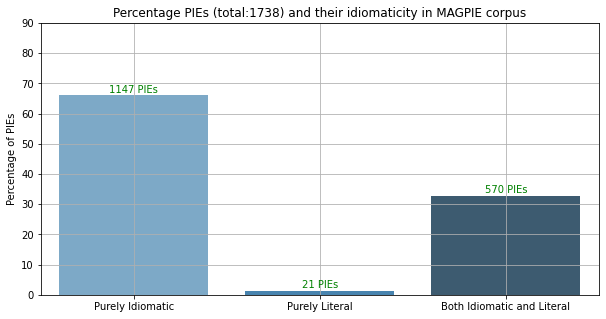

In [9]:
num_of_pies = [len(purely_idiom_PIEs), len(purely_literal_PIEs), len(both_idiom_n_literal_PIEs)]
total_pies = sum(num_of_pies)
percent_of_pies = [cnt/total_pies*100 for cnt in num_of_pies]

category = ['Purely Idiomatic', 'Purely Literal', 'Both Idiomatic and Literal']
plt.figure(figsize=(10,5))
ax = sns.barplot(x=category, y=percent_of_pies, palette="Blues_d")

# Display the actual numbers on the bars
for x_tick,(num,percents) in enumerate(zip(num_of_pies, percent_of_pies)):
    ax.text(x_tick, percents+1, f"{num} PIEs", color='green', ha='center')

plt.yticks(np.arange(0, 100, 10))
plt.grid()
plt.rcParams['grid.alpha'] = 0.5

plt.title(f'Percentage PIEs (total:{total_pies}) and their idiomaticity in MAGPIE corpus')
plt.ylabel('Percentage of PIEs')
plt.show()

In [10]:
# How is the distribution of number of idiom versus literal sentences?
df_pie_with_both_labels = df_tok_label_counts[df_tok_label_counts['idiom_token'].isin(both_idiom_n_literal_PIEs)]
df_pie_with_both_labels

,idiom_token,label,num_of_examples,total,idiomaticity_ratio
4,IDontheshelfID,idiom,4,134,0.029851
5,IDontheshelfID,literal,130,134,0.970149
16,IDpeachesandcreamID,idiom,2,5,0.400000
17,IDpeachesandcreamID,literal,3,5,0.600000
28,IDfireinthebellyID,idiom,1,2,0.500000
...,...,...,...,...,...
3461,IDoutcoldID,literal,2,19,0.105263
3466,IDgooverboardID,idiom,31,35,0.885714
3467,IDgooverboardID,literal,4,35,0.114286
3472,IDnightanddayID,idiom,42,68,0.617647


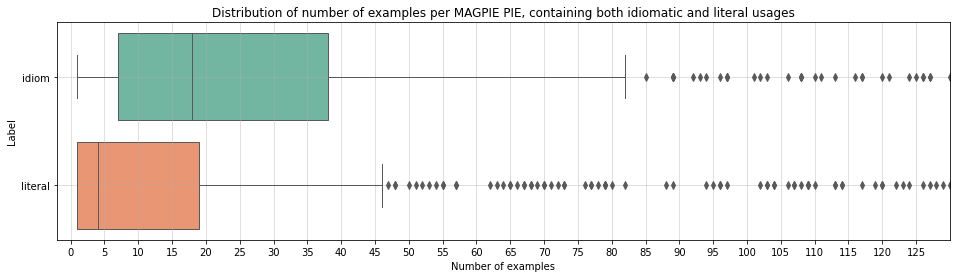

In [11]:
# Plot the distributions
plt.figure(figsize=(16,4))
sns.boxplot(x='num_of_examples', y='label', orient="h", palette="Set2", \
            linewidth=1, data=df_pie_with_both_labels)

plt.xlim([-2, 130])
plt.xticks(np.arange(0, 130, 5))

plt.grid()
plt.rcParams['grid.alpha'] = 0.5

plt.title("Distribution of number of examples per MAGPIE PIE, containing both idiomatic and literal usages")
plt.xlabel('Number of examples')
plt.ylabel('Label')
plt.show()

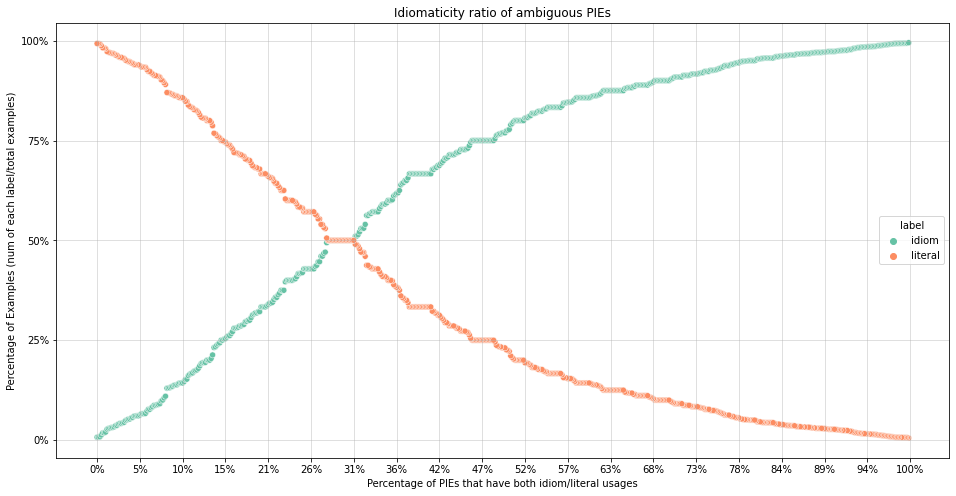

In [12]:
# Percentage of idiomatic versus literal usage, per each PIE
df_vis = df_pie_with_both_labels.copy()
df_vis['idiomaticity_ratio'] = df_vis['idiomaticity_ratio'] * 100
df_vis = df_vis.sort_values(by=['label', 'idiomaticity_ratio'])
num_of_unique = len(df_vis['idiom_token'].unique())

# Plot the idiomaticity ratios
plt.figure(figsize=(16,8))
ax = sns.scatterplot(x='idiom_token', y='idiomaticity_ratio', hue='label', palette="Set2", data=df_vis)
plt.ylabel("Percentage of Examples (num of each label/total examples)")
y_locs = [y for y in np.linspace(0, 100, 5)]
y_ticks = [f"{int(y)}%" for y in y_locs]
plt.yticks(y_locs, y_ticks)

# Reduce num of ticks on x axis and convert to percentages
plt.xlabel('Percentage of PIEs that have both idiom/literal usages')
tick_locs = [x for x in np.linspace(0, num_of_unique, num=20)]
tick_vals = [x/num_of_unique*100 for x in tick_locs]
tick_vals = [f"{int(tv)}%" for tv in tick_vals]
plt.xticks(tick_locs, tick_vals)

plt.grid()
plt.title("Idiomaticity ratio of ambiguous PIEs")
plt.show()

## Output
Decided to create 3 groups based on the degree of idiomaticity (or ambiguity):
- highly idiomatic
- ambiguous
- highly literal

In [13]:
# Below this, PIE is highly literal
THRESHOLD_MIN = 0.2
# Above this, PIE is highly idiomatic
THRESHOLD_MAX = 0.8
# In-between the two is ambiguous

def get_degree_category(idiomaticity_ratio):
    if idiomaticity_ratio <= THRESHOLD_MIN:
        return 'highly_literal'
    elif idiomaticity_ratio >= THRESHOLD_MAX:
        return 'highly_idiomatic'
    else:
        # Between THRESHOLD_MIN and THRESHOLD_MAX
        return 'ambiguous'

# NOTE: instead of only idiom, we can also take only literal here; BUT you have to change the above thresholds
df_only_idiom_labels = df_tok_label_counts[df_tok_label_counts['label'] == LABEL_IDIOM]
# Create three category mappings
tok_degree_mapping = {}
for i,row in df_only_idiom_labels.iterrows():
    tok_degree_mapping[row['idiom_token']] = get_degree_category(row['idiomaticity_ratio'])

# Add a new column
df_tok_label_counts['degree_of_idiomaticity'] = df_tok_label_counts['idiom_token'].map(tok_degree_mapping)
df_tok_label_counts

,idiom_token,label,num_of_examples,total,idiomaticity_ratio,degree_of_idiomaticity
0,IDcometothinkofitID,idiom,129,129,1.000000,highly_idiomatic
1,IDcometothinkofitID,literal,0,129,0.000000,highly_idiomatic
2,IDliveandletliveID,idiom,10,10,1.000000,highly_idiomatic
3,IDliveandletliveID,literal,0,10,0.000000,highly_idiomatic
4,IDontheshelfID,idiom,4,134,0.029851,highly_literal
...,...,...,...,...,...,...
3471,IDpulloutallthestopsID,literal,0,39,0.000000,highly_idiomatic
3472,IDnightanddayID,idiom,42,68,0.617647,ambiguous
3473,IDnightanddayID,literal,26,68,0.382353,ambiguous
3474,IDkickupastinkID,idiom,5,5,1.000000,highly_idiomatic


Visualize the distribution of PIEs with different "Degree of Idiomaticity" 

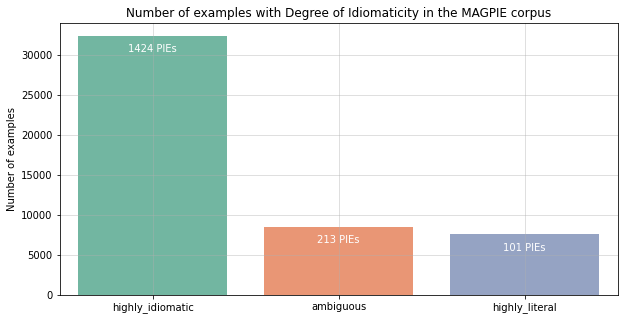

In [14]:
# Visualize the distribution of PIEs with different "Degree of Idiomaticity" 

df_vis = df_tok_label_counts[df_tok_label_counts['label'] == LABEL_IDIOM]
df_vis = df_vis[['degree_of_idiomaticity', 'total']].reset_index()
df_grp = df_vis.groupby('degree_of_idiomaticity', as_index=False).agg({'total': 'sum', 'index': 'count'})
total_count_dict = {item['degree_of_idiomaticity']:item['total'] for item in df_grp.to_dict(orient='records')}
pie_count_dict = {item['degree_of_idiomaticity']:item['index'] for item in df_grp.to_dict(orient='records')}

x_labels = ['highly_idiomatic', 'ambiguous', 'highly_literal']
y_vals = [total_count_dict[x] for x in x_labels]
y_heads = [pie_count_dict[x] for x in x_labels]
y_heads = [f"{pc} PIEs" for pc in y_heads]

plt.figure(figsize=(10,5))
ax= sns.barplot(x=x_labels, y=y_vals, palette="Set2")

# Display the actual numbers on the bars
for x_tick,(val, head) in enumerate(zip(y_vals, y_heads)):
    ax.text(x_tick, val-2000, head, color='white', ha='center')

plt.title(f'Number of examples with Degree of Idiomaticity in the MAGPIE corpus')
plt.ylabel('Number of examples')

plt.grid()
plt.show()

## Save the PIE groups with different Degree of Idiomaticity

In [15]:
# display(df_tok_label_counts)
df_tok_label_counts.to_csv(output_file, index=False)
print(f"Saved the PIE Segregation file at {output_file}")

Saved the PIE Segregation file at ../data/PIE_segregation/pie_segregation.csv


## 2. Groups based on 'Rarity' of PIEs

* PIEs in the **'test dataset'** with a high, medium and low number of examples in the processed "CC News Dataset"
1. ccnews_frequent
2. ccnews_moderately_rare
3. ccnews_very_rare

In [16]:
pie_counts_from_cc_news_file = '../experiments/exp3B_1/pretrain_data_split/cc_news_pie_counts.json'

In [17]:
# # The CC News training file used to pre-train the Masked-LM is used here
# cc_training_file = '/home/darshan/work/course/dissertation/idiom_principle_on_magpie_corpus/experiments/exp3B_1/pretrain_data_split/train.txt'

# # Count the number of lines containing each PIE
# pie_count_dict = defaultdict(int)
# with open(cc_training_file) as cc_file:
#     for line in cc_file.readlines():
#         for mtok in magpie_token_set:
#             if mtok in line:
#                 pie_count_dict[mtok] += 1
# # Dump the file, for future use
# with open(pie_counts_from_cc_news_file, 'w') as fout:
#     json.dump(pie_count_dict, fout)
#     print(f"Dumped the PIE counts in CCNews corpus at{pie_counts_from_cc_news_file}")

# Load the preprocessed PIE counts of CC news corpus
with open(pie_counts_from_cc_news_file, 'r') as fin:
    pie_count_dict = json.load(fin)
    print(f"Loaded the pre-computed dict file from {pie_counts_from_cc_news_file}")

Loaded the pre-computed dict file from ../experiments/exp3B_1/pretrain_data_split/cc_news_pie_counts.json


In [18]:
row_list = [{'idiom_token':k, 'num_of_sentences':v}for k,v in pie_count_dict.items()]
df_ccnews_pie_counts = pd.DataFrame(row_list)
df_ccnews_pie_counts

,idiom_token,num_of_sentences
0,IDontherunID,3005
1,IDspotonID,3186
2,IDinbusinessID,10762
3,IDtoatID,10460
4,IDforafricaID,2539
...,...,...
1260,IDdoginthemangerID,3
1261,IDmakeheadortailofID,1
1262,IDmuddythewatersID,2
1263,IDcruisingforabruisingID,1


,percentile,num_of_sentences
0,0.0,1.00
1,2.5,1.00
2,7.5,2.00
3,10.0,2.00
4,15.0,3.00
5,25.0,7.00
6,50.0,32.00
7,75.0,136.00
8,90.0,480.80
9,99.0,4173.44


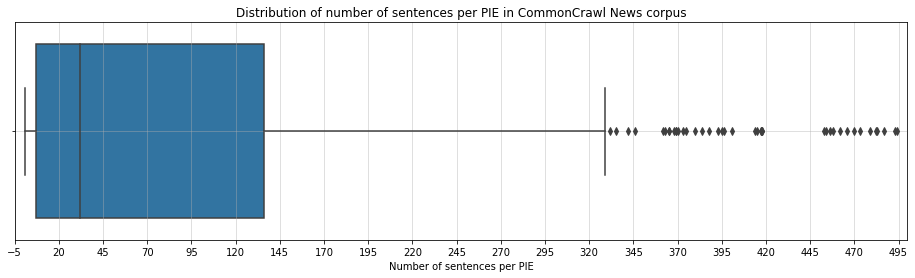

In [19]:
# Distribution of number of examples per PIEs
percentiles = [0, 0.025, 0.075, 0.1, 0.15, 0.25, 0.50, 0.75, 0.9, 0.99]
df_quantiles = df_ccnews_pie_counts['num_of_sentences'].quantile(percentiles)
df_quantiles = pd.DataFrame(df_quantiles)
df_quantiles = df_quantiles.reset_index().rename(columns={'index': 'percentile'})
df_quantiles['percentile'] = df_quantiles['percentile'] * 100
display(df_quantiles)

# Visualization of the same
plt.figure(figsize=(16,4))
sns.boxplot(x='num_of_sentences', data=df_ccnews_pie_counts)

# Ignore the outliers
plt.xlim([-5, 500])
plt.xlabel("Number of sentences per PIE")
plt.xticks(list(range(-5, 500, 25)))

plt.title("Distribution of number of sentences per PIE in CommonCrawl News corpus")
plt.grid()
plt.rcParams['grid.alpha'] = 0.3
plt.show()

## Output
Categorize the PIEs into 3 groups, based on their frequency of occurance in the CommonCrawl News corpus.

**Thresholds:**
- 25% of the PIEs have greater than 136 sentences in the CC News corpus
- 25% of the PIEs have less than 7 sentences in the CC News corpus

Hence, taking the inter-quartile range as moderately-rare examples seems reasonable.

In [20]:
THRESHOLD_MIN = df_quantiles[df_quantiles['percentile'] == 25]['num_of_sentences'].values[0]
THRESHOLD_MIN = int(THRESHOLD_MIN)

THRESHOLD_MAX = df_quantiles[df_quantiles['percentile'] == 75]['num_of_sentences'].values[0]
THRESHOLD_MAX = int(THRESHOLD_MAX)

print(f"Threshould min:{THRESHOLD_MIN} and Threshold max:{THRESHOLD_MAX}")

Threshould min:7 and Threshold max:136


In [21]:
def get_rarity_category(num_of_sentences):
    if num_of_sentences < THRESHOLD_MIN:
        return 'ccnews_very_rare'
    elif num_of_sentences > THRESHOLD_MAX:
        return 'ccnews_frequent'
    else:
        return 'ccnews_moderately_rare'

#Add a column to the dataframe
df_ccnews_pie_counts['ccnews_rarity'] = df_ccnews_pie_counts['num_of_sentences'].map(lambda nos: get_rarity_category(nos))
# Convert to a dictionary
pie_rarity_map = {r['idiom_token']:r['ccnews_rarity'] for r in df_ccnews_pie_counts.to_dict(orient='records')}
pie_rarity_map

{'IDontherunID': 'ccnews_frequent',
 'IDspotonID': 'ccnews_frequent',
 'IDinbusinessID': 'ccnews_frequent',
 'IDtoatID': 'ccnews_frequent',
 'IDforafricaID': 'ccnews_frequent',
 'IDnotcricketID': 'ccnews_moderately_rare',
 'IDbehindbarsID': 'ccnews_frequent',
 'IDleftandrightID': 'ccnews_frequent',
 'IDtakerootID': 'ccnews_frequent',
 'IDplanbID': 'ccnews_frequent',
 'IDaroundtheclockID': 'ccnews_frequent',
 'IDcomecleanID': 'ccnews_frequent',
 'IDbearinmindID': 'ccnews_frequent',
 'IDfollowsuitID': 'ccnews_frequent',
 'IDdowntheroadID': 'ccnews_frequent',
 'IDunderthesunID': 'ccnews_frequent',
 'IDwaytogoID': 'ccnews_frequent',
 'IDbehindthescenesID': 'ccnews_frequent',
 'IDgoallthewayID': 'ccnews_frequent',
 'IDtietheknotID': 'ccnews_frequent',
 'IDgameonID': 'ccnews_frequent',
 'IDinthelongrunID': 'ccnews_frequent',
 'IDgetthebetterofID': 'ccnews_frequent',
 'IDlasthurrahID': 'ccnews_frequent',
 'IDhaveafewID': 'ccnews_frequent',
 'IDheartofgoldID': 'ccnews_frequent',
 'IDonthebacko

In [22]:
# Add another column to the existing df_tok_label_counts dataframe
df_tok_label_counts['ccnews_rarity'] = df_tok_label_counts['idiom_token'].map(lambda tok: pie_rarity_map[tok] if tok in pie_rarity_map else 'ccnews_very_rare')
print("Added one more column to df_tok_label_counts DataFrame!")
df_tok_label_counts

Added one more column to df_tok_label_counts DataFrame!


,idiom_token,label,num_of_examples,total,idiomaticity_ratio,degree_of_idiomaticity,ccnews_rarity
0,IDcometothinkofitID,idiom,129,129,1.000000,highly_idiomatic,ccnews_moderately_rare
1,IDcometothinkofitID,literal,0,129,0.000000,highly_idiomatic,ccnews_moderately_rare
2,IDliveandletliveID,idiom,10,10,1.000000,highly_idiomatic,ccnews_moderately_rare
3,IDliveandletliveID,literal,0,10,0.000000,highly_idiomatic,ccnews_moderately_rare
4,IDontheshelfID,idiom,4,134,0.029851,highly_literal,ccnews_frequent
...,...,...,...,...,...,...,...
3471,IDpulloutallthestopsID,literal,0,39,0.000000,highly_idiomatic,ccnews_moderately_rare
3472,IDnightanddayID,idiom,42,68,0.617647,ambiguous,ccnews_very_rare
3473,IDnightanddayID,literal,26,68,0.382353,ambiguous,ccnews_very_rare
3474,IDkickupastinkID,idiom,5,5,1.000000,highly_idiomatic,ccnews_very_rare


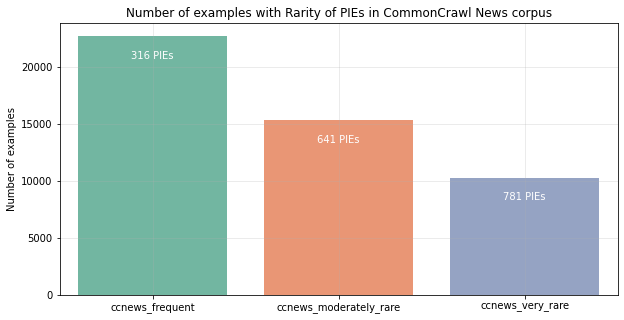

In [23]:
# Visualize teh distributions of PIEs based on their rarity

df_vis = df_tok_label_counts[df_tok_label_counts['label'] == LABEL_IDIOM]
df_vis = df_vis[['ccnews_rarity', 'total']].reset_index()
df_grp = df_vis.groupby('ccnews_rarity', as_index=False).agg({'total': 'sum', 'index': 'count'})
total_count_dict = {item['ccnews_rarity']:item['total'] for item in df_grp.to_dict(orient='records')}
pie_count_dict = {item['ccnews_rarity']:item['index'] for item in df_grp.to_dict(orient='records')}

x_labels = ['ccnews_frequent', 'ccnews_moderately_rare', 'ccnews_very_rare']
y_vals = [total_count_dict[x] for x in x_labels]
y_heads = [pie_count_dict[x] for x in x_labels]
y_heads = [f"{pc} PIEs" for pc in y_heads]

plt.figure(figsize=(10,5))
ax= sns.barplot(x=x_labels, y=y_vals, palette="Set2")

# Display the actual numbers on the bars
for x_tick,(val, head) in enumerate(zip(y_vals, y_heads)):
    ax.text(x_tick, val-2000, head, color='white', ha='center')

plt.title(f'Number of examples with Rarity of PIEs in CommonCrawl News corpus')
plt.ylabel('Number of examples')

plt.grid()
plt.show()

## Save the PIE groups with different CCNews 'Rarity groups'

In [24]:
df_tok_label_counts.to_csv(output_file, index=False)
print(f"Saved the CCNews Rarity grouping at {output_file}")

Saved the CCNews Rarity grouping at ../data/PIE_segregation/pie_segregation.csv


## 3. Groups based on 'Morphological Variations' of PIEs

PIEs with very few morphological variaionts (high number of exact matches in the MAGPIE sentences), versus very high morphological variations in the MAGPIE corpus

The three categories:

1. **no_morphology** - PIEs with no morphological variations at all
2. **moderate_morphology** - PIEs between 1 to *THRESHOLD* different variations only
3. **high_morphology** - PIEs more than *THRESHOLD* variations

In [25]:
# Load the original processed MAGPIE corpus, which contains the raw sentences before replacing with PIE tokens
magpie_raw_file = data_dir + '/magpie/processed_MAGPIE_filtered_split_typebased.csv'
df_magpie_raw = pd.read_csv(magpie_raw_file)
df_magpie_raw

,sentence_0,idiom,confidence,label,split,variant_type,offsets
0,"For example , with fell running and mountain m...",off the beaten track,1.000000,i,training,identical,"[[117, 120], [125, 131], [132, 137]]"
1,I 'd keep him well in the running .,in the running,0.770109,i,training,identical,"[[19, 21], [26, 33]]"
2,"He gives me the creeps , so I looked round , h...",give someone the creeps,1.000000,i,training,combined-inflection,"[[3, 8], [9, 11], [16, 22]]"
3,"‘ He 's done us proud , as well,’ says Granvil...",do someone proud,1.000000,i,training,combined-inflection,"[[8, 12], [13, 15], [16, 21]]"
4,"People quickly embraced formal democracy , but...",take root,1.000000,i,training,identical,"[[136, 140], [141, 145]]"
...,...,...,...,...,...,...,...
48390,Many also have second or third jobs to make en...,make ends meet,0.854973,i,test,identical,"[[39, 43], [44, 48], [49, 53]]"
48391,"Take people to objections , take them to where...",bear in mind,1.000000,i,training,identical,"[[71, 75], [76, 78], [79, 83]]"
48392,"Indeed we are rarely aware of them as rules , ...",as a rule,1.000000,l,training,deletion-determiner,"[[35, 37], [38, 43]]"
48393,Unlike in a firm that is a jack of all trades ...,jack of all trades,1.000000,i,training,identical,"[[27, 31], [32, 34], [35, 38], [39, 45]]"


In [26]:
# Use 'variant_type' column
df_magpie_raw['variant_type'].value_counts()

identical               23513
inflection               8183
combined-inflection      5080
dashes                   3217
case                     1665
combined-other           1410
insertion-other          1409
misc                      987
determiner-broad          765
deletion-determiner       612
possessive                562
determiner-narrow         452
insertion-determiner      374
objective                 166
Name: variant_type, dtype: int64

In [27]:
# These variations are considered exact-match
identical_types = set(['identical', 'dashes', 'case', 'misc'])
# Remaining all variations are non-exact match

In [28]:
# Find all the PIEs and number of variation kinds
df_tmp = df_magpie_raw[['idiom', 'variant_type']]
idiom_phrase_variation_counts = {}

for idiom,df_grp in df_tmp.groupby('idiom', as_index=False):
    var_types = set(df_grp['variant_type'].unique())
    # If there are no variations other than identical_types
    variations = var_types - identical_types
    if len(variations) == 0:
        # This idiom has only exact matches
        idiom_phrase_variation_counts[idiom] = 0 # 0 variation
    else:
        # This idiom has variations
        idiom_phrase_variation_counts[idiom] = len(variations) # Number of variations

# PIEs with their variation counts
idiom_phrase_variation_counts

{"Bob's your uncle": 0,
 'Dutch courage': 0,
 "Hobson's choice": 0,
 "I'll eat my hat": 0,
 'Indian summer': 0,
 'Jekyll and Hyde': 0,
 'Pyrrhic victory': 0,
 "a hair's breadth": 0,
 'a little bird told me': 2,
 'a penny for your thoughts': 2,
 'a pretty penny': 1,
 'above board': 3,
 'above par': 0,
 'across the board': 5,
 'act of God': 2,
 'add fuel to the fire': 5,
 'add insult to injury': 2,
 'against the grain': 4,
 'ahead of the curve': 0,
 'ahead of the game': 1,
 'alive and kicking': 2,
 'all along': 0,
 'all and sundry': 0,
 'all bets are off': 1,
 'all dressed up and nowhere to go': 0,
 'all hell broke loose': 2,
 "all in a day's work": 0,
 'all over bar the shouting': 0,
 'all over the map': 1,
 'all over the place': 2,
 'all over the shop': 1,
 'all over the show': 0,
 'all the rage': 1,
 'all things being equal': 3,
 'all wet': 0,
 'along about': 0,
 "an Englishman's home is his castle": 0,
 'an old flame': 3,
 'and all that jazz': 0,
 'and then some': 0,
 'any port in a 

In [29]:
# Merge the idiom_phrase_variation_counts with PIE tokens using df_token_mapping
df_pie_exact_match_status = df_token_mapping.copy()
df_pie_exact_match_status['variations'] = df_pie_exact_match_status['idiom'].map(idiom_phrase_variation_counts)
df_pie_exact_match_status

,idiom,idiom_token,variations
0,off the beaten track,IDoffthebeatentrackID,2
1,in the running,IDintherunningID,2
2,give someone the creeps,IDgivesomeonethecreepsID,2
3,do someone proud,IDdosomeoneproudID,3
4,take root,IDtakerootID,3
...,...,...,...
1733,there's no fool like an old fool,IDtheresnofoollikeanoldfoolID,0
1734,top banana,IDtopbananaID,0
1735,all dressed up and nowhere to go,IDalldressedupandnowheretogoID,0
1736,keep your nose clean,IDkeepyournosecleanID,0


In [43]:
# Get the total number of CC news sentences per each category of 'number of variations'
# This should answer the question: are PIEs with no morphology occure less frequently?
left_df = df_pie_exact_match_status[['idiom_token', 'variations']]
right_df = df_ccnews_pie_counts[['idiom_token', 'num_of_sentences']]
df_merged = pd.merge(left_df, right_df, on='idiom_token', how='left')
# Fill NaN with 0
df_merged['num_of_sentences'] = df_merged['num_of_sentences'].map(lambda num: 0 if np.isnan(num) else num)
df_sum_of_sents = df_merged.groupby('variations', as_index=False)['num_of_sentences'].sum()
df_sum_of_sents

,variations,num_of_sentences
0,0,56662.0
1,1,43101.0
2,2,65587.0
3,3,39041.0
4,4,36287.0
5,5,43400.0
6,6,17767.0
7,7,14589.0


In [50]:
variations_total_sents_dict = {d['variations']:d['num_of_sentences'] for d in df_sum_of_sents.to_dict(orient='records')}
variations_total_sents_dict = {str(k):v for k,v in variations_total_sents_dict.items()}
variations_total_sents_dict
# df_sum_of_sents['num_of_sentences'].sum()

{'0': 56662.0,
 '1': 43101.0,
 '2': 65587.0,
 '3': 39041.0,
 '4': 36287.0,
 '5': 43400.0,
 '6': 17767.0,
 '7': 14589.0}

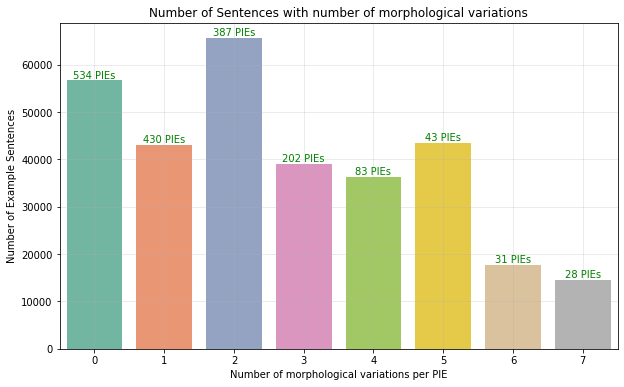

In [55]:
# Visualize the number of PIEs with number of variations seen in MAGPIE corpus
df_pie_variation_counts = df_pie_exact_match_status.groupby('variations', as_index=False)['idiom'].count()
df_pie_variation_counts = df_pie_variation_counts.rename(columns={'idiom':'num_of_pies'})
df_pie_variation_counts['variations'] = df_pie_variation_counts['variations'].map(lambda v: str(v))
pie_var_count_dict = {r['variations']:r['num_of_pies'] for r in df_pie_variation_counts.to_dict(orient='records')}

x_labels = sorted(pie_var_count_dict.keys())
y_vals = [variations_total_sents_dict[x] for x in x_labels]
y_heads = [pie_var_count_dict[x] for x in x_labels]
y_heads = [f"{pc} PIEs" for pc in y_heads]

plt.figure(figsize=(10,6))
ax= sns.barplot(x=x_labels, y=y_vals, palette="Set2")

# Display the actual numbers on the bars
for x_tick,(val, head) in enumerate(zip(y_vals, y_heads)):
    ax.text(x_tick, val+500, head, color='green', ha='center')

plt.xlabel('Number of morphological variations per PIE')

plt.ylabel('Number of Example Sentences')
plt.title("Number of Sentences with number of morphological variations")
plt.grid()
plt.show()

### Output

Using 1(inclusive) to 4(inclusie) morphological variations as **moderately morphology**

In [31]:
THRESHOLD_MIN = 1
THRESHOLD_MAX = 4

def get_morphology_category(num_of_variations):
    if num_of_variations < THRESHOLD_MIN:
        return 'no_morphology'
    elif num_of_variations < THRESHOLD_MAX:
        return 'moderate_morphology'
    else:
        return 'high_morphology'

df_tmp = df_pie_exact_match_status[['idiom_token', 'variations']]
df_tmp['morphology_type'] = df_tmp['variations'].map(get_morphology_category)
df_tmp = df_tmp[['idiom_token', 'morphology_type']]
pie_morphology_dict = {r['idiom_token']:r['morphology_type'] for r in df_tmp.to_dict(orient='records')}
pie_morphology_dict

{'IDoffthebeatentrackID': 'moderate_morphology',
 'IDintherunningID': 'moderate_morphology',
 'IDgivesomeonethecreepsID': 'moderate_morphology',
 'IDdosomeoneproudID': 'moderate_morphology',
 'IDtakerootID': 'moderate_morphology',
 'IDcleanhouseID': 'moderate_morphology',
 'IDmakehistoryID': 'high_morphology',
 'IDgoallthewayID': 'high_morphology',
 'IDchapterandverseID': 'moderate_morphology',
 'IDbreakthebankID': 'moderate_morphology',
 'IDheadforthehillsID': 'moderate_morphology',
 'IDinafogID': 'high_morphology',
 'IDbringuptherearID': 'moderate_morphology',
 'IDintheholeID': 'high_morphology',
 'IDtruetoformID': 'no_morphology',
 'IDragstorichesID': 'no_morphology',
 'IDontheballID': 'high_morphology',
 'IDstakeaclaimID': 'high_morphology',
 'IDupforgrabsID': 'moderate_morphology',
 'IDupandrunningID': 'no_morphology',
 'IDbehindbarsID': 'high_morphology',
 'IDinmybookID': 'high_morphology',
 'IDinblackandwhiteID': 'no_morphology',
 'IDgoupinsmokeID': 'moderate_morphology',
 'IDup

In [32]:
# Add another column to the existing df_tok_label_counts dataframe
df_tok_label_counts['morphology_type'] = df_tok_label_counts['idiom_token'].map(pie_morphology_dict)
print("Added one more column to df_tok_label_counts DataFrame!")
df_tok_label_counts

Added one more column to df_tok_label_counts DataFrame!


,idiom_token,label,num_of_examples,total,idiomaticity_ratio,degree_of_idiomaticity,ccnews_rarity,morphology_type
0,IDonehorseraceID,idiom,4,4,1.000000,highly_idiomatic,ccnews_very_rare,no_morphology
1,IDonehorseraceID,literal,0,4,0.000000,highly_idiomatic,ccnews_very_rare,no_morphology
2,IDservesomeonerightID,idiom,68,69,0.985507,highly_idiomatic,ccnews_very_rare,moderate_morphology
3,IDservesomeonerightID,literal,1,69,0.014493,highly_idiomatic,ccnews_very_rare,moderate_morphology
4,IDallovertheplaceID,idiom,76,98,0.775510,ambiguous,ccnews_frequent,moderate_morphology
...,...,...,...,...,...,...,...,...
3471,IDcutthecrapID,literal,0,9,0.000000,highly_idiomatic,ccnews_moderately_rare,moderate_morphology
3472,IDpullafaceID,idiom,131,138,0.949275,highly_idiomatic,ccnews_very_rare,high_morphology
3473,IDpullafaceID,literal,7,138,0.050725,highly_idiomatic,ccnews_very_rare,high_morphology
3474,IDbleedingheartID,idiom,6,6,1.000000,highly_idiomatic,ccnews_moderately_rare,moderate_morphology


## Save PIE groups with different degree of Morphological variations 

In [33]:
df_tok_label_counts.to_csv(output_file, index=False)
print(f"Saved the Morphological variation based grouping at {output_file}")

Saved the Morphological variation based grouping at ../data/PIE_segregation/pie_segregation.csv
